# MARATONA BEHIND THE CODE 2021

## DESAFIO 5: SONDA

##### Autor: Rodrigo Oliveira
##### LinkedIn: https://www.linkedin.com/in/rodrigolima82/

# Parte 01. Importando as bibliotecas

In [1]:
# Pacotes padrao
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

# Pacote ML
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, f1_score
from sklearn.preprocessing import MinMaxScaler

# Desativando warnings no jupyter
import warnings
warnings.filterwarnings('ignore')

# Parte 02. Carregando o Dataset

In [2]:
# Carregando o dataset
dataset = pd.read_csv('../data/dataset.csv')

# Remove registros vazios
dataset.dropna(inplace = True)   

# Carregando o dataset ANSWERS
answers = pd.read_csv('../data/ANSWERS.csv')

# Realizando o join com answers
fullDF = dataset.append(answers)

# Exibindo quantidade de registros
print('Dataset shape: ', dataset.shape)
print('Teste shape: ', answers.shape)
print('Full shape: ', fullDF.shape)

Dataset shape:  (4106, 21)
Teste shape:  (1324, 21)
Full shape:  (5430, 21)


# Parte 03. Tratamento dos dados

In [3]:
def fe(df):
    
    # Transformando algumas variaveis string para inteiro
    cleanup_nums = {
                    "PARTNER":          {"No": 0, "Yes": 1},
                    "DEPENDENTS":       {"No": 0, "Yes": 1},
                    "PHONESERVICE":     {"No": 0, "Yes": 1},
                    "INTERNETSERVICE":  {"DSL": 1, "Fiber optic": 2, "No": 0},
                    "ONLINESECURITY":   {"No": 0, "Yes": 1, "No internet service": -1},
                    "ONLINEBACKUP":     {"No": 0, "Yes": 1, "No internet service": -1},
                    "DEVICEPROTECTION": {"No": 0, "Yes": 1, "No internet service": -1},
                    "TECHSUPPORT":      {"No": 0, "Yes": 1, "No internet service": -1},
                    "STREAMINGTV":      {"No": 0, "Yes": 1, "No internet service": -1},
                    "STREAMINGMOVIES":  {"No": 0, "Yes": 1, "No internet service": -1},
                    "CONTRACT":         {"Month-to-month": 0, "Two year": 0.5, "One year": 1},
                    "PAPERLESSBILLING": {"No": 0, "Yes": 1},
                    "PAYMENTMETHOD":    {"Credit card (automatic)": 0, "Electronic check": 1, "Mailed check": 2, "Bank transfer (automatic)": 3},
                    "CHURN":            {"No": 0, "Yes": 1, "TO_FILL": -1},
                    "TOTALCHARGES":     {' ': -99}                    
                    }

    # Aplicando a transformacao
    df.replace(cleanup_nums, inplace=True)

    # Transformando a coluna em float
    df['TOTALCHARGES'] = pd.to_numeric(df['TOTALCHARGES'])

    # Calculando o produto entre colunas
    df["TENURE_TOTALCHARGES_prod"] = df["TENURE"] * df["TOTALCHARGES"]
    df["TENURE_MONTHLYCHARGES_prod"] = df["TENURE"] * df["MONTHLYCHARGES"]
    df["MONTHLYCHARGES_TOTALCHARGES_prod"] = df["MONTHLYCHARGES"] * df["TOTALCHARGES"]

    # Realizando uma transformacao logaritma na variavel MONTHLYCHARGES
    df["MONTHLYCHARGES_log"] = np.log1p(df["MONTHLYCHARGES"])
    df["MONTHLYCHARGES_TOTALCHARGES_prod_log"] = np.log1p(df["MONTHLYCHARGES_TOTALCHARGES_prod"])

    # Separa dataset de treino e teste depois de aplicar Feature Engineering
    train = df[df['CHURN'] != -1]
    test = df[df['CHURN'] == -1]

    return train, test    

In [4]:
# Aplicando Feature Engineering
treino, teste = fe(fullDF)

In [5]:
# Remove registros nulos apos aplicar funcao logaritima
treino.dropna(inplace = True)

In [6]:
# Exibindo quantidade de registros
print('Treino shape: ', treino.shape)
print('Teste shape: ', teste.shape)

Treino shape:  (4103, 26)
Teste shape:  (1324, 26)


# Parte 04. Modelagem Preditiva

In [7]:
# features do modelo
features = ['SENIORCITIZEN',
            'DEPENDENTS',
            'PHONESERVICE',
            'INTERNETSERVICE',
            'ONLINESECURITY',
            'ONLINEBACKUP',
            'TECHSUPPORT',
            'STREAMINGTV',
            'STREAMINGMOVIES',
            'CONTRACT',
            'PAPERLESSBILLING',
            'PAYMENTMETHOD',
            'MONTHLYCHARGES_log',
            'TENURE_TOTALCHARGES_prod',
            'TENURE_MONTHLYCHARGES_prod',
            'MONTHLYCHARGES_TOTALCHARGES_prod'
            ]

# coluna a ser prevista
target   = ['CHURN']

In [8]:
# Selecionando features para treinamento
X = treino[features]

# Selecionando feature target
y = treino[target]

# Split dos dados
X_treino, X_val, y_treino, y_val = train_test_split(X, y, test_size = .2, random_state = 42, stratify = y)    

# Aplica scala 
scaler = MinMaxScaler()
X_treino = scaler.fit_transform(X_treino)
X_val = scaler.transform(X_val)


In [9]:
# Modelo de Regressao Logistica
model = LogisticRegression(solver='liblinear', random_state=42)

# Fit do modelo
model.fit(X_treino, y_treino)

# Calculando previsoes
y_pred_val = model.predict(X_val)


In [10]:
print('Training set score: {:.4f}'.format(model.score(X_treino, y_treino)))

print('Test set score: {:.4f}'.format(model.score(X_val, y_val)))

print("f1 Score (Test): {:.4f}".format(f1_score(y_val, y_pred_val, average='weighted')))

Training set score: 0.7974
Test set score: 0.8270
f1 Score (Test): 0.8223


In [11]:
def performance_model(model):

    # Calcula o score com dados de teste
    score = f1_score(y_val, y_pred_val, average='weighted')

    # Cria a matriz de confusão
    conf_matriz = confusion_matrix(y_val, y_pred_val)
        
    # Matriz de Confusão gráfica
    sns.set(rc={'figure.figsize':(6, 6)})
    sns.heatmap(conf_matriz, 
                annot = True, 
                fmt = ".0f", 
                linewidths = .5, 
                square = True, 
                cmap = 'RdBu_r')

    # Labels e Títulos
    plt.ylabel('Label Verdadeiro')
    plt.xlabel('Label Previsto')
    plt.title('F1 Score: {:.2f}'.format(score), size = 15)

    # Relatório de Classificação
    print(classification_report(y_val, y_pred_val))

    return score

              precision    recall  f1-score   support

           0       0.86      0.91      0.89       605
           1       0.70      0.60      0.65       216

    accuracy                           0.83       821
   macro avg       0.78      0.75      0.77       821
weighted avg       0.82      0.83      0.82       821



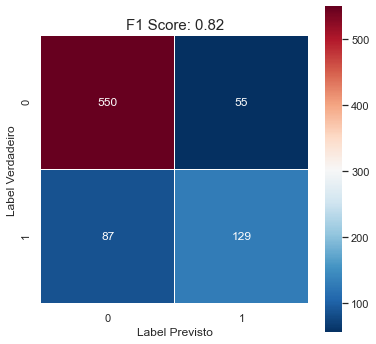

In [12]:
score = performance_model(model)

# Parte 05. Realizando Previsoes

In [17]:
# Apenas feature no dataset de test
X_teste = teste[features]

# Aplica scala
X_teste = scaler.transform(X_teste)

# Visualiza
print(X_teste.shape)
X_teste

(1324, 16)


array([[0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        4.36258837e-04, 6.22883391e-03, 1.57629118e-03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        7.38093908e-02, 1.07859040e-01, 1.87603217e-02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        6.10368196e-01, 5.87537987e-01, 4.85591198e-01],
       ...,
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        6.72096569e-01, 5.59042571e-01, 5.25585835e-01],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        1.31879285e-02, 3.23168784e-03, 1.84020124e-03],
       [1.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        7.51461643e-01, 4.18552053e-01, 3.75835925e-01]])

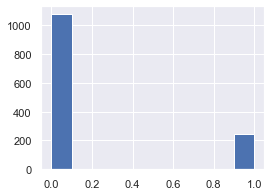

In [18]:
# Carregando o dataset ANSWERS
answers = pd.read_csv('../data/ANSWERS.csv')

# Realizando previsoes com dados de answers
answers['CHURN'] = model.predict(X_teste)

sns.set(rc={'figure.figsize':(4, 3)})
plt.figure() 

plt.hist(model.predict(X_teste))
plt.show()

# Parte 06. Salvar resultado

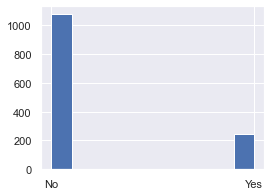

In [19]:
# Retornando valor original para coluna CHURN
change_value = {"CHURN": {0: "No", 1: "Yes"}}

# Aplicando a transformacao
answers.replace(change_value, inplace=True)

answers.to_csv('../submissao/ANSWERS.csv', index=False)
plt.hist(answers.CHURN)
plt.show()